# Exercise - Outlier detection

In this exercise, you will implement outlier detection algorithms described in the lecture. 

For task 1, you will implement the slow algorithm, and for task 2, you will implement the faster one. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import heapq as hq
import time

## generate data

To generate some data with outliers for this exercise, we're going to sample some data from a 
distribution with known parameters, modify the parameters, and continue sampling to generate 
some outliers.  In particular, we'll sample our data from a 
[multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) by using [numpy.random.multivariate_normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html) method. 

Run the following cell to define a function to generate input data with specified number of dimensions.

In [2]:
def generate_data(dim, num_initial_points):
    
    """
    Input: Integer dim is the dimensionality of the data to generate, 
    integer num_initial_points is the number of original data points to generate. 
    
    Action: Generate some data with some outliers. 
    Start with generating num_initial_points data points by sampling from a multivariate normal distribution.
    Then, iteratively add more data points to generate some outliers.  
    
    Output: Numpy array with dim dimensions 
    """

    np.random.seed(10)
    
    # Create covariance matrix & mean vector
    mean = np.zeros(dim)
    covar = np.zeros((dim,dim))
    np.fill_diagonal(covar, 1)

    # Sample num_initial_points data points 
    # from multivariate normal distribution 
    # with pre-defined mean and covariance
    all_data = np.random.multivariate_normal(mean, covar, num_initial_points)   
    
    # Start adding more data points to all_data to generate some outliers
    for i in range (10):
        mean.fill(2*i+5)
        more_data = np.random.multivariate_normal (mean, covar, (i+1)**2)
        all_data = np.concatenate ((all_data, more_data))             
    return all_data

Let's visualize 2 dimensional data generated by `generate_data()`. 

In [3]:
data_2d = generate_data(2, 3000)

On the generated data, row indices up to 3000 belong to initial data points, and the rest of data points are extra data added iteratively to generate outliers.   

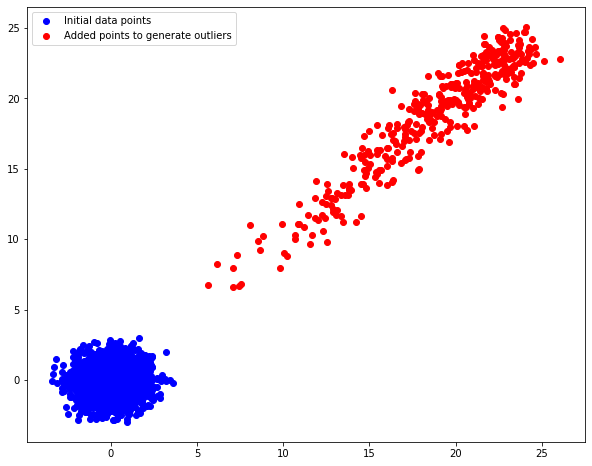

In [4]:
fig, axs = plt.subplots(figsize=(10,8))
axs.scatter(data_2d[:3000,0], data_2d[:3000,1], c='b', label='Initial data points')
axs.scatter(data_2d[3000:,0], data_2d[3000:,1], c='r', label='Added points to generate outliers')
axs.legend()

For this exercise, we generate data with 100 dimensionality and with 3000 initial data points.

In [5]:
data_100d = generate_data(100, 3000)
print (len(data_100d))

3385


**Expected Output**

Based on our provided code to generate data, we generate growing batches of points clustered around increasing means. The most outlierly points will start at index `num_initial_points`. 

So, if you run outlier detection algorithm on `data_100d`, and you're looking for top 5 outliery points, the correct expected outlier indices are `3000`, `3001`, `3002`, `3003`, `3004`.  

## Task 1 - slow algorithm (25 pts)

In the first part of this exercise, your task is to complete the function below by implementing the slow algorithm of outlier detection described in the lecture. To recall, here is the pseudocode: 

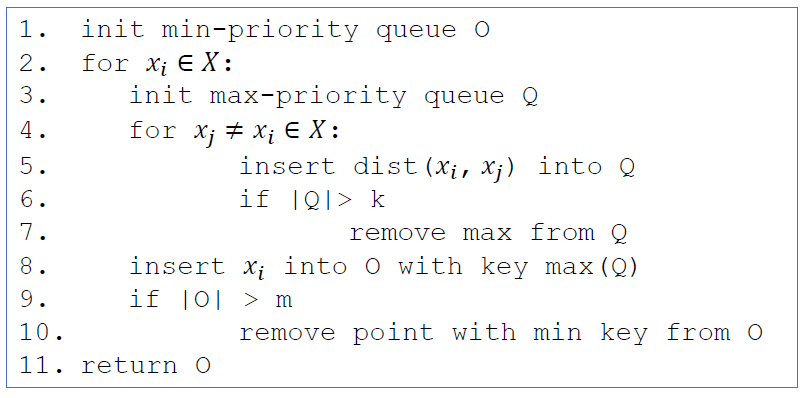



To implement the priority queue, use Python's [heapq](https://docs.python.org/3/library/heapq.html). The distance between data points will be implemented using Euclidean distance (the l2-norm).

In [6]:
def get_outliers_slow(data, k=10, num_outliers=5):
    
    """
    Input: Numpy array data, interger k is the kth nearest neighbor to consider, 
    integer num_outliers is the number of outliers we are looking for
    
    Action: Implement the slower algorithm of finding distance-based outliers 
    
    Output: List of outliers (built as priority queue) with num_outliers entries;
    entries are (key, value) tuples, 
    key is the Euclidean distance between the outlier and its kth nearest neighbor, 
    value is the index of the outlier point in the input data   
    """
    
    # Priority Queue for the outliers
    # Entries of this queue must be tuples of (key, value)
    # Keys are Euclidean distances
    # Values are indices of data points 
    outliers = []
    
    # Enter you code here ...
    for i in range(len(data)):
        myMaxHeap = []
        for j in range(len(data)):
            if i != j:
                dist = np.linalg.norm(data[i] - data[j])
                hq.heappush(myMaxHeap, -1*dist)
                if len(myMaxHeap) > k:
                    hq.heappop(myMaxHeap)
                
        x = -1*hq.heappop(myMaxHeap)
        hq.heappush(outliers, (x, i))
    
        if len(outliers) > num_outliers:
            hq.heappop(outliers)
        
    return outliers

Run the below cells to call your implemented `get_outliers_slow()` function on the generated data with 100 dimensionality (`data_100d`) in order to find the 5 most outliery points (`num_outliers=5`) by considering the 10th (`k=10`) nearest neighbor. We also want to calculate the run time of your implemented slow algorithm.

In [7]:
start_time = time.time()
outliers_slow = get_outliers_slow(data_100d, 10, 5)
end_time = time.time()

In [8]:
print("Here is the list of detected outliers:")
outliers_slow

Here is the list of detected outliers:


[(23.72374367892497, 3003),
 (25.340148860874006, 3001),
 (25.459569062524572, 3004),
 (25.518460762934513, 3002),
 (41.8295991591954, 3000)]

In [9]:
print("Run time of the slow algorithm of outlier detection = ", end_time-start_time, "(sec)")

Run time of the slow algorithm of outlier detection =  375.57997727394104 (sec)


## Task 2 - faster algorithm (25 pts)

In the second part of this exercise, your task is to complete the function below by implementing the fast algorithm of outlier detection described in the lecture. To recall, here is the pseudocode:

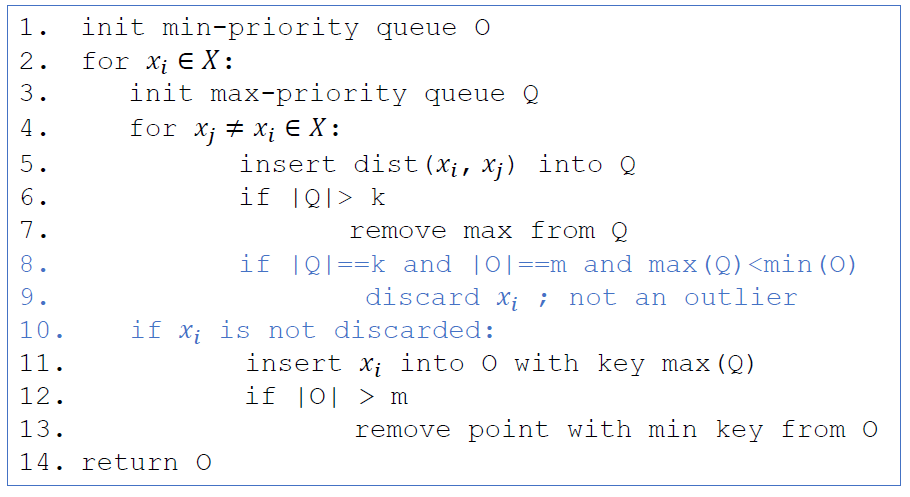



In [10]:
def get_outliers_fast(data, k=10, num_outliers=5):
    """
    Input: Numpy array data, interger k is the kth nearest neighbor to consider, 
    integer num_outliers is the number of outliers we are looking for
    
    Action: Implement the slower algorithm of finding distance-based outliers 
    
    Output: List of outliers (built as priority queue) with num_outliers entries;
    entries are (key, value) tuples, 
    key is the Euclidean distance between the outlier and its kth nearest neighbor, 
    value is the index of the outlier point in the input data   
    """
    
    # Priority Queue for the outliers
    # Entries of this queue must be tuples of (key, value)
    # Keys are Euclidean distances
    # Values are indices of data points 
    outliers = []
    
    # Enter you code here ...
    for i in range(len(data)):
        myMaxHeap = []
        for j in range(len(data)):
            if i != j:
                dist = np.linalg.norm(data[i] - data[j])
                hq.heappush(myMaxHeap, -1*dist)
                if len(myMaxHeap) > k:
                    hq.heappop(myMaxHeap)
                if len(myMaxHeap) == k and len(outliers) == num_outliers and -1*myMaxHeap[0] < outliers[0][0]:
                    break
        x = -1*hq.heappop(myMaxHeap)
        hq.heappush(outliers, (x, i))
    
        if len(outliers) > num_outliers:
            hq.heappop(outliers)
            
    return outliers

Run the below cells to call your implemented `get_outliers_fast()` function on the generated data with 100 dimensionality (`data_100d`) in order to find the 5 most outliery points (`num_outliers=5`) by considering the 10th (`k=10`) nearest neighbor. We also want to calculate the run time of your implemented fast algorithm.

In [11]:
start_time = time.time()
outliers_fast = get_outliers_fast(data_100d)
end_time = time.time()

In [12]:
print("Here is the list of detected outliers:")
outliers_fast

Here is the list of detected outliers:


[(23.72374367892497, 3003),
 (25.340148860874006, 3001),
 (25.459569062524572, 3004),
 (25.518460762934513, 3002),
 (41.8295991591954, 3000)]

In [13]:
print("Run time of the fast algorithm of outlier detection = ", end_time-start_time, "(sec)")

Run time of the fast algorithm of outlier detection =  73.66776132583618 (sec)


## Shuffling data to run even faster!

If we shuffle data to store data points in a randomized order of indices, we can get even run our fast algorithm faster! 

Try this by running the following cells.

In [14]:
np.random.seed(10)
# Note that this code shuffles the contents of data_100d in-place.
np.random.shuffle(data_100d)

In [15]:
start_time = time.time()
outliers_fast_shuffled = get_outliers_fast(data_100d)
end_time = time.time()

In [16]:
print("Here is the list of detected outliers:")
outliers_fast_shuffled

Here is the list of detected outliers:


[(23.72374367892497, 1599),
 (25.340148860874006, 1262),
 (41.8295991591954, 1973),
 (25.518460762934513, 87),
 (25.459569062524572, 870)]

Note that since you've shuffled the data, the indices of the outliers will change, but the distances should be the same.

In [17]:
print("Run time of the faster algorithm of outlier detection = ", end_time-start_time, "(sec)")

Run time of the faster algorithm of outlier detection =  24.359368801116943 (sec)


Copyright ©  2020 Rice University, Christopher M Jermaine (cmj4@rice.edu), Risa B Myers  (rbm2@rice.edu), and Marmar Orooji (marmar.orooji@rice.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.